<a href="https://colab.research.google.com/github/Gobs140103/DeepLearningProject_PaddyDisease/blob/main/PaddyDiseaseClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.
Found 3469 files belonging to 10 classes.
Epoch 1/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4349 - loss: 1.6691
Epoch 1: val_accuracy improved from -inf to 0.76069, saving model to best_paddy_disease_classifier.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 103s 325ms/step - accuracy: 0.4354 - loss: 1.6679 - val_accuracy: 0.7607 - val_loss: 0.8091
Epoch 2/40
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7473 - loss: 0.7935
Epoch 2: val_accuracy improved from 0.76069 to 0.83133, saving model to best_paddy_disease_classifier.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 43s 163ms/step - accuracy: 0.7474 - loss: 0.7932 - val_accuracy: 0.8313 - val_loss: 0.5856
Epoch 3/40
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8338 - loss: 0.5461
Epoch 3: val_accuracy improved from 0.83133 to 0.86881, saving model to best_paddy_disease_c

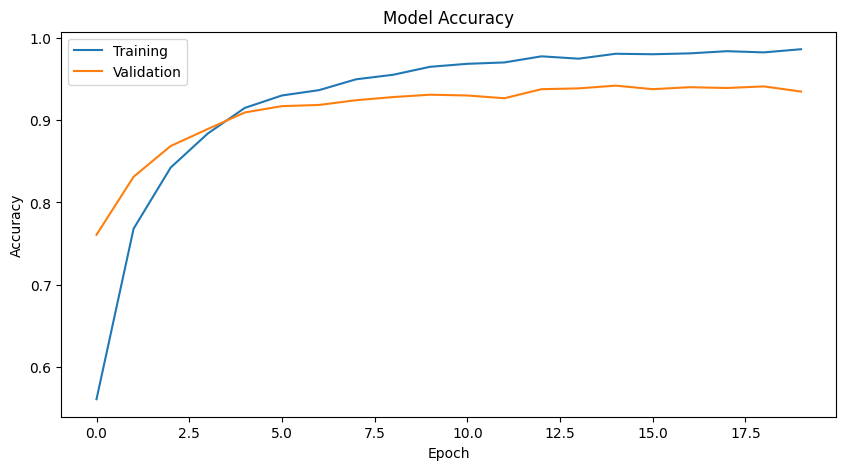

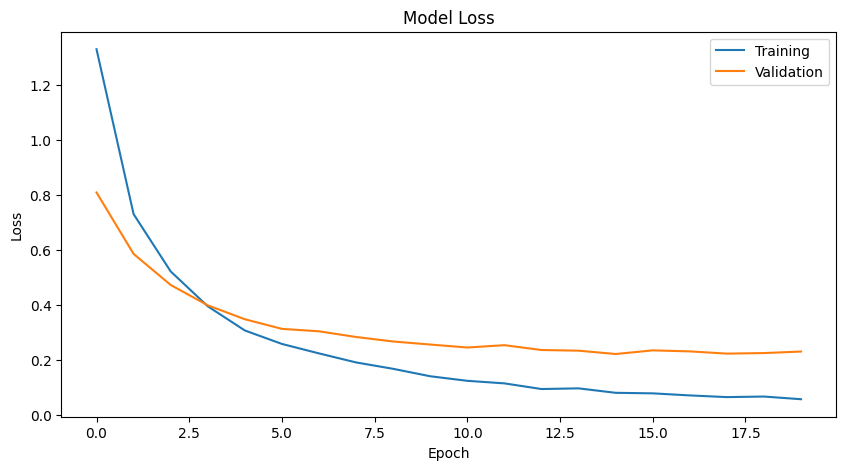

109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.9385 - loss: 0.2187
Test Accuracy: 94.35%
Test Loss: 0.2017
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step

Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.95      0.88      0.92       167
   bacterial_leaf_streak       0.98      0.96      0.97       127
bacterial_panicle_blight       0.93      0.95      0.94       113
                   blast       0.93      0.97      0.95       575
              brown_spot       0.95      0.88      0.92       315
              dead_heart       0.97      0.96      0.97       480
            downy_mildew       0.93      0.93      0.93       200
                   hispa       0.93      0.96      0.94       539
                  normal       0.94      0.96      0.95       589
                  tungro       0.96      0.91      0.94       364

                accuracy                           0.94      3469
               macro

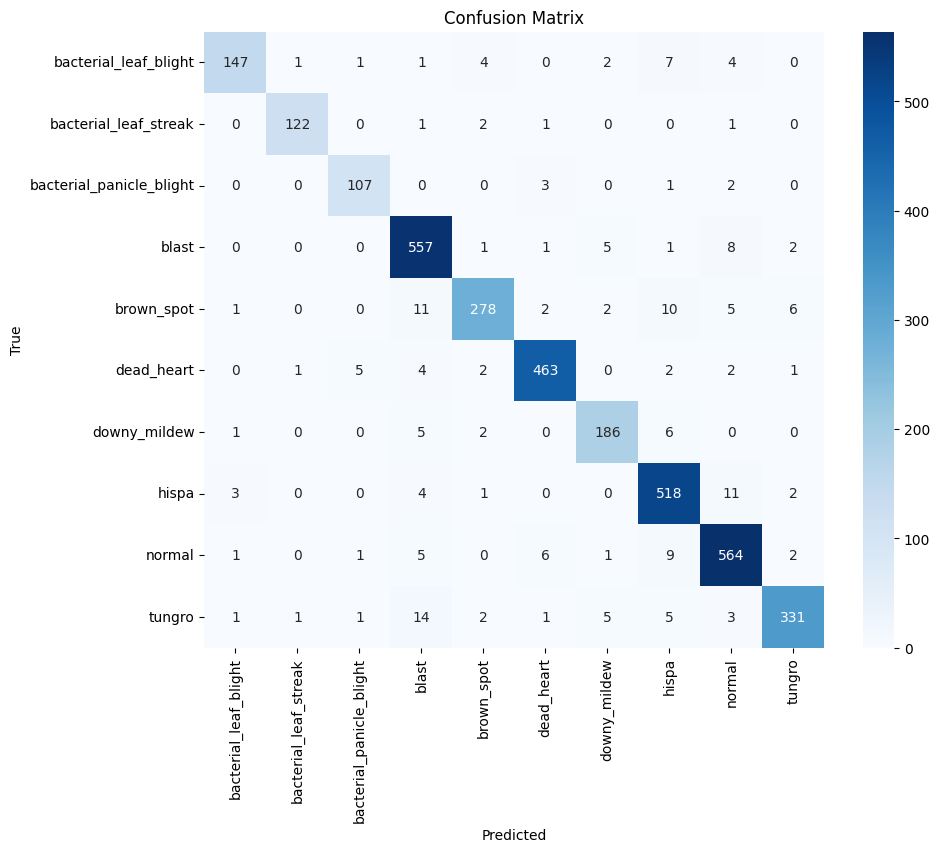

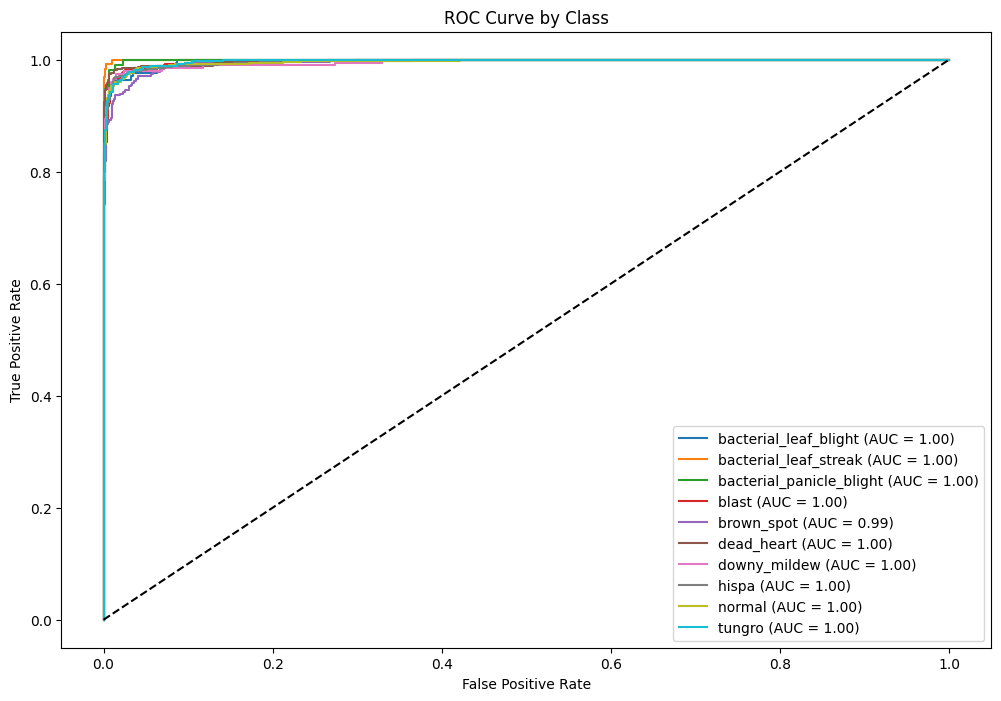


Average ROC-AUC Score: 0.9971


In [13]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer

train_path = '/content/paddy/paddy-disease-classification/train_images'

test_path = '/content/paddy/paddy-disease-classification/labeled_test_images'

classes = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast',
           'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode="categorical"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    batch_size=32,
    image_size=(224, 224),
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical"
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    batch_size=32,
    image_size=(224, 224),
    label_mode="categorical",
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    AveragePooling2D(2, 2),
    Flatten(),
    Dense(220, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    'best_paddy_disease_classifier.keras', monitor='val_accuracy', save_best_only=True, verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop, checkpoint])

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.concatenate([np.argmax(y, axis=1) for x, y in test_ds], axis=0)

print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=classes))

conf_mat = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

lb = LabelBinarizer()
true_bin = lb.fit_transform(true_classes)
pred_bin = lb.transform(pred_classes)

plt.figure(figsize=(12, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_bin[:, i], preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class')
plt.legend(loc='lower right')
plt.show()

avg_auc = roc_auc_score(true_bin, preds, average="macro")
print(f"\nAverage ROC-AUC Score: {avg_auc:.4f}")

model.save('final_paddy_disease_classifier.keras')